In [48]:
import os
import random
import string
from collections import Counter, defaultdict
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt

In [49]:
# Define paths
images_path = 'data/Images'
captions_file = 'data/captions.txt'

In [50]:
# Creates a dictionary, with the image name as the key, and the caption as the value
captions = defaultdict(list)
with open(captions_file, 'r') as f:
    next(f)  # Skip the header
    for line in f:
        image, caption = line.strip().split(',', 1)
        captions[image].append(caption)

In [51]:
# Example caption
captions['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [53]:
# Preprocess captions and clean the text up
def clean_caption(caption):
    # Remove punctuation
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    # Remove words with numbers and words of length 1
    # If the word is of length 1, or the word contains a digit, remove it from the cpation
    caption = ' '.join([word for word in caption.split() if len(word) > 1 and not any(char.isdigit() for char in word)])
    # Convert to lowercase
    caption = caption.lower()
    return caption

# Surprisingly loops over all keys
for image in captions:
    # Loops over all strings, and cleans the captions
    captions[image] = [clean_caption(caption) for caption in captions[image]]

In [55]:
# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # TODO: Update this part of the function
    transforms.Lambda(lambda x: x[:3, :, :]),  # Ensure the image has 3 channels
])

# Load image function helper
def load_image(image_file):
    image = Image.open(os.path.join(images_path, image_file)).convert('RGB')
    image = transform(image)
    return image

In [56]:
# Build vocabulary
word_counter = Counter()
for image, caption_list in captions.items():
    # Loops through list of strings
    for caption in caption_list:
        word_counter.update(caption.split())

In [57]:
# Create dictionaries for words
vocab_threshold = 3
vocab = [word for word, count in word_counter.items() if count > vocab_threshold]
vocab_size = len(vocab) + 4  # Including <PAD>, <START>, <END>, <UNK>

In [58]:
# Add special tokens
stoi = {word: idx + 4 for idx, word in enumerate(vocab)}
stoi['<PAD>'] = 0
stoi['<START>'] = 1
stoi['<END>'] = 2
stoi['<UNK>'] = 3
itos = {idx: word for word, idx in stoi.items()}

In [60]:
def encode_caption(caption):
    # Default entry for dictionary.get()
    encoded = [stoi['<START>']] + [stoi.get(word, stoi['<UNK>']) for word in caption.split()] + [stoi['<END>']]
    return encoded

def decode_caption(encoded_caption):
    # Default entry for dictionary.get()
    return ' '.join([itos.get(idx, '<UNK>') for idx in encoded_caption])

def pad_caption(caption, max_length):
    # This actually pads one less than the max, which is not intended. But, we will keep this anyways
    return caption + [stoi['<PAD>']] * (max_length - len(caption))

In [82]:
# Calculate the max length of the cpations
# To unpack this, we are looping over the defaultdict captions. We get the list of strings called caption_list, and loop over all lists of strings in captions, and also loop over all captions in the list
# This is a very complex string comprehension
max_length = max(len(caption.split()) for caption_list in captions.values() for caption in caption_list) + 2
max_length

34

In [85]:
# Loops over all image keys, all caption lists, all captions in caption lists, encodes them, and pads them
encoded_captions = defaultdict(list)

for image in captions:
    for caption in captions[image]:
        encoded = encode_caption(caption)
        padded = pad_caption(encoded, max_length)
        encoded_captions[image].append(padded)

In [65]:
# Function to create input and target sequences
def create_sequences(encoded_caption):
    input_sequence = encoded_caption[:-1]
    target_sequence = encoded_caption[1:]
    return input_sequence, target_sequence

In [67]:
# Create input and target sequences for all captions
input_sequences = defaultdict(list)
target_sequences = defaultdict(list)

for image, caption_list in encoded_captions.items():
    for caption in caption_list:
        # Loop through all captions in all caption_lists, and create the corresponding token lists
        input_seq, target_seq = create_sequences(caption)
        # Create another defaultdict() that allows for indexing of the processed list tokens
        input_sequences[image].append(input_seq)
        target_sequences[image].append(target_seq)

In [68]:
# Creating randomized batches
image_keys = list(captions.keys())

In [69]:
torch.manual_seed(1337)

In [70]:
# Shuffle the dataset
shuffled_indices = torch.randperm(len(image_keys)).tolist()
image_keys = [image_keys[i] for i in shuffled_indices]

In [71]:
# Split the dataset (80% training, 20% validation)
split_index = int(0.8 * len(image_keys))
train_keys = image_keys[:split_index]
val_keys = image_keys[split_index:]

In [72]:
# Train and validation sets
train_captions = {key: captions[key] for key in train_keys}
val_captions = {key: captions[key] for key in val_keys}
train_input_sequences = {key: input_sequences[key] for key in train_keys}
val_input_sequences = {key: input_sequences[key] for key in val_keys}
train_target_sequences = {key: target_sequences[key] for key in train_keys}
val_target_sequences = {key: target_sequences[key] for key in val_keys}

In [73]:
def create_batch(caption_dict, input_seq_dict, target_seq_dict, batch_size):
    images_batch = []
    input_captions_batch = []
    target_captions_batch = []
    
    selected_images = random.sample(list(caption_dict.keys()), batch_size)
    for image in selected_images:
        # Pick a random index from one of the caption lists
        selected_caption_idx = random.randint(0, len(caption_dict[image]) - 1)
        # Add the corresponding image caption
        input_captions_batch.append(input_seq_dict[image][selected_caption_idx])
        # Get the corresponding target_caption
        target_captions_batch.append(target_seq_dict[image][selected_caption_idx])
        # Add the image to the corresponding image to the image set
        images_batch.append(load_image(image))
    
    images_batch = torch.stack(images_batch)
    input_captions_batch = torch.tensor(input_captions_batch)
    target_captions_batch = torch.tensor(target_captions_batch)
    
    return images_batch, input_captions_batch, target_captions_batch


In [29]:
# Example usage:
batch_size = 64
images_batch, input_captions_batch, target_captions_batch = create_batch(train_captions, train_input_sequences, train_target_sequences, batch_size)


In [30]:
images_batch.shape

torch.Size([64, 3, 224, 224])

In [31]:
input_captions_batch.shape

torch.Size([64, 33])

In [32]:
target_captions_batch.shape

torch.Size([64, 33])

Training example:


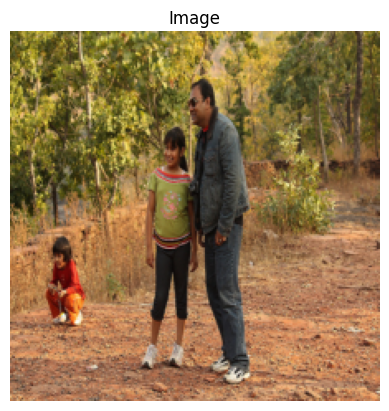

Input Caption: <START> man stands with two children in wooded area looking at something in the distance <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target Caption: man stands with two children in wooded area looking at something in the distance <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Validation example:


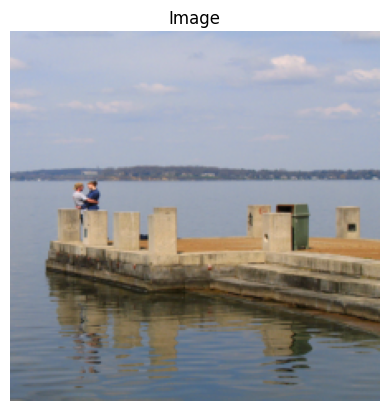

Input Caption: <START> two people stand on the pier looking at the ocean and embrace <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Target Caption: two people stand on the pier looking at the ocean and embrace <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [33]:
def visualize_example(caption_dict, input_seq_dict, target_seq_dict):
    # Select a random image
    random_image = random.choice(list(caption_dict.keys()))
    
    # Select a random caption index for the chosen image
    caption_idx = random.randint(0, len(caption_dict[random_image]) - 1)
    
    # Load the image
    image_tensor = load_image(random_image)
    image_array = image_tensor.permute(1, 2, 0).numpy()
    
    # Get the corresponding caption inputs and targets
    input_caption_encoded = input_seq_dict[random_image][caption_idx]
    target_caption_encoded = target_seq_dict[random_image][caption_idx]
    input_caption = decode_caption(input_caption_encoded)
    target_caption = decode_caption(target_caption_encoded)
    
    # Plot the image
    plt.imshow(image_array)
    plt.axis('off')
    plt.title('Image')
    plt.show()
    
    # Print the input and target captions
    print(f"Input Caption: {input_caption}")
    print(f"Target Caption: {target_caption}")

# Example usage:
print("Training example:")
visualize_example(train_captions, train_input_sequences, train_target_sequences)

print("Validation example:")
visualize_example(val_captions, val_input_sequences, val_target_sequences)


In [34]:
# Define a residual block for MLP architecture
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        
        super(ResBlockMLP, self).__init__()
        
        # Define layer normalization for input size
        self.norm1 = nn.LayerNorm(input_size)
        
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, input_size//2)
        
        # Layer normalization for input size // 2
        self.norm2 = nn.LayerNorm(input_size//2)
        
        # Second fully connected layer
        self.fc2 = nn.Linear(input_size//2, output_size)
        
        # Final fully connected layer
        self.fc3 = nn.Linear(input_size, output_size)
        
        # Activation function
        self.act = nn.ELU()

    def forward(self, x):
        
        # Apply layer normalization and activation function
        x = self.act(self.norm1(x))
        
        # Calculate skip connection
        skip = self.fc3(x)
        
        # Apply layer normalization, fully connected layer, and activation function
        x = self.act(self.norm2(self.fc1(x)))
        x = self.fc2(x)
        
        # Add skip connection
        return x + skip

In [75]:
class ConvNet(nn.Module):
    def __init__(self, channels_in, dropout):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(channels_in, out_channels = 32, padding = 2, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, out_channels = 64, padding = 2, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(channels_in, out_channels = 128, padding = 2, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(channels_in, out_channels = 256, padding = 2, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2)

        self.dropout = nn.Dropout(dropout)

        self.act = nn.ReLU()
        
        self.linear1 = nn.Linear(50176, 4096)
    
    def forward(self, inputs): # (224, 224, 3)
        
        out = self.maxpool(self.dropout(self.bn1(self.act(self.conv1(inputs))))) # (112, 112, 32)
        
        out = self.maxpool(self.dropout(self.bn2(self.act(self.conv2(out))))) # (56, 56, 64)
        
        out = self.maxpool(self.dropout(self.bn3(self.act(self.conv3(out))))) # (28, 28, 128)
        
        out = self.maxpool(self.dropout(self.bn4(self.act(self.conv4(out))))) # (14, 14, 256)
        
        return self.linear1(out) # (B, 4096)
        

In [76]:
class Decoder(nn.Module):
    def __init__(self, channels_in, dropout, vocab_size, emb_size, hidden_size, num_layers, num_blocks):
        super(Decoder, self).__init__()
        
        self.convnet = ConvNet(channels_in = 3, dropout = dropout)

        self.embedding = nn.Embedding(vocab_size, emb_size)
        
        # Define LSTM layer
        self.lstm = nn.LSTM(input_size = emb_size, hidden_size = hidden_size, num_layers = num_layers, bias = False, batch_first = True)

        # Residual blocks
        blocks = [ResBlockMLP(hidden_size, hidden_size) for _ in range(num_blocks)]

        # Activation function
        self.act = nn.ELU()
        
        # Define the output fully connected layer
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    # Memory in will always be a matrice of zeros
    def forward(self, images, captions, mem_in):

        features = self.convnet(images) # (B, 4096)
        
        features = features.unsqueeze(0) # (1, B, 4096)
        
        outputs, (_, _) = self.lstm(captions, (features, mem_in))
        # x = (B, T, emb_size)
        # hidden_out = (num_layers, B, hidden_size)
        # mem_out = (num_layers, B, hidden_size)

        outputs = self.act(self.block(outputs))
        
        return self.fc_out(outputs) 

In [77]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

num_iterations = 1000

hidden_size = 256

learning_rate = 1e-4

channels_in = 3

dropout = 0.2

vocab_size = len(stoi)

emb_size = 128

hidden_size = 256

num_layers = 1

num_blocks = 2

batch_size = batch_size

max_length = max_length

model = Decoder(channels_in = channels_in, dropout = dropout, vocab_size = vocab_size, emb_size = emb_size, hidden_size = hidden_size, num_layers = num_layers, num_blocks = num_blocks).to(device)

memory = torch.zeros(num_layers, batch_size, hidden_size, device=device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

training_loss = []

valid_loss = []

In [80]:
# Let's see how many Parameters our model has!
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("This model Has %d Parameters" % (num_model_params))

-This Model Has 207268322 Parameters!


In [87]:
for iteration in range(num_iterations):

    model.train()

    image_batch, caption_batch, label_batch = create_batch(train_captions, train_input_sequences, train_target_sequences, 2)

    print("here")
    
    outputs = model(image_batch, caption_batch, memory)

    outputs = outputs.reshape(batch_size * max_length, -1)

    loss = loss_fn(outputs, train_labels)

    print("training loss:", loss)

    break

    
    
    

here


RuntimeError: Given groups=1, weight of size [128, 3, 3, 3], expected input[2, 64, 57, 57] to have 3 channels, but got 64 channels instead